<a href="https://colab.research.google.com/github/christiandoramo/Variantes-para-o-epsilon/blob/adaptative/Variantes_do_epsilon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tema 2: Variantes para o epsilon <br>
Equipe: <br>
Christian Oliveira <br>
Raphael Barbosa <br>

Info: [tema 2](https://docs.google.com/document/d/1bpqsUML8XkUVBMjiKMLNwbG3npgaF_35xQYrh-Dp4Ts/edit?tab=t.0#heading=h.rs93iuj1gddv )

# Recapitulações

## Configurações Iniciais

In [2]:
#clear_output()

In [3]:
from IPython.display import clear_output
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # for saving videos
    !apt-get install ffmpeg

    !pip install gymnasium moviepy

    # clone repository
    !git clone https://github.com/pablo-sampaio/rl_facil
    sys.path.append("/content/rl_facil")

    clear_output()
else:
    from os import path
    sys.path.append( path.dirname( path.dirname( path.abspath("__main__") ) ) )

### Imports Gerais

In [4]:
import gymnasium as gym
import numpy as np

In [5]:
from util.experiments import repeated_exec
from util.plot import plot_result, plot_multiple_results
from util.notebook import display_videos_from_path
from util.qtable_helper import evaluate_qtable_policy, record_video_qtable

In [6]:
# define se os algoritmos vão imprimir dados do treinamento
VERBOSE = True

## 1. Q-Learning

Veremos aqui, vários algoritmos da família *Temporal-Difference Learning* de 1 passo. Todos eles se baseiam na em uma estimativa da função $Q(s,a)$. Porém, diferente dos Monte Carlo, eles apresendem a cada passo de interação com o episódio.

Ao invés do retorno parcial real $G_t$, todos usam uma estimativa *bootstraped* baseada nas equações de Bellamn.

Após uma experiência $(s,a,r,s')$, eles atualizam $Q$ assim:

$$
Q(s,a) \leftarrow Q(s,a) + \alpha \times (r + \gamma V(s') - Q(s,a))
$$

O método **Q-Learning** tem como característica a suposição de que, a partir de s', será executada a ação "gulosa". Assim, ele assume que um $s'$ não-terminal terá seu valor dado pela ação de melhor valor (retorno futuro a partir dela):

$$
V(s') = max_{a'}(Q(s',a'))
$$

In [77]:
# Esta é a política. Neste caso, escolhe uma ação com base nos valores
# da tabela Q, usando uma estratégia epsilon-greedy.
def epsilon_greedy(Q, state, epsilon):
    num_actions = len(Q[state])
    if np.random.random() < epsilon:
        return np.random.randint(0, num_actions)
    else:
        return np.argmax(Q[state])   # em caso de empates, retorna sempre o menor índice --> mais eficiente, porém...
        #return np.random.choice(np.where(Q[state] == Q[state].max())[0]) # aleatoriza em caso de empates

In [8]:
# Algoritmo Q-learning
# Atenção: os espaços de estados e de ações precisam ser discretos, dados por valores inteiros
def run_qlearning(env, episodes, lr=0.1, gamma=0.95, epsilon=0.1):
    assert isinstance(env.observation_space, gym.spaces.Discrete)
    assert isinstance(env.action_space, gym.spaces.Discrete)

    num_actions = env.action_space.n

    # inicializa a tabela Q toda com zeros
    # usar o estado como índice das linhas e a ação como índice das colunas
    Q = np.zeros(shape = (env.observation_space.n, num_actions))

    # para cada episódio, guarda sua soma de recompensas (retorno não-descontado)
    all_episode_rewards = []

    # loop principal
    for i in range(episodes):
        done = False
        sum_rewards, reward = 0, 0

        state, _ = env.reset()

        # executa 1 episódio completo, fazendo atualizações na Q-table
        while not done:
            # escolhe a próxima ação -- usa epsilon-greedy
            action = epsilon_greedy(Q, state, epsilon)

            # realiza a ação, ou seja, dá um passo no ambiente
            next_state, reward, terminated, trunc, _ = env.step(action)
            done = terminated or trunc

            if terminated:
                # para estados terminais
                V_next_state = 0
            else:
                # para estados não-terminais -- valor máximo (melhor ação)
                V_next_state = np.max(Q[next_state])

            # atualiza a Q-table
            # delta = (estimativa usando a nova recompensa) - estimativa antiga
            delta = (reward + gamma * V_next_state) - Q[state,action]
            Q[state,action] = Q[state,action] + lr * delta

            sum_rewards += reward
            state = next_state

        all_episode_rewards.append(sum_rewards)

        # a cada 100 episódios, imprime informação sobre o progresso
        if VERBOSE and ((i+1) % 100 == 0):
            avg_reward = np.mean(all_episode_rewards[-100:])
            print(f"Episode {i+1} Average Reward (last 100): {avg_reward:.3f}")

    return all_episode_rewards, Q

In [9]:
#ENV_NAME, r_max = "Taxi-v3", 10
ENV_NAME, r_max = "CliffWalking-v0", 0

EPISODES = 8_000
LR = 0.01
GAMMA = 0.95
EPSILON = 0.05

env = gym.make(ENV_NAME, max_episode_steps=500)

# Roda o algoritmo Q-Learning
rewards1, qtable1 = run_qlearning(env, EPISODES, LR, GAMMA, EPSILON)
clear_output()

print("Últimos resultados: media =", np.mean(rewards1[-20:]), ", desvio padrao =", np.std(rewards1[-20:]))

Últimos resultados: media = -24.65 , desvio padrao = 33.318575899939056


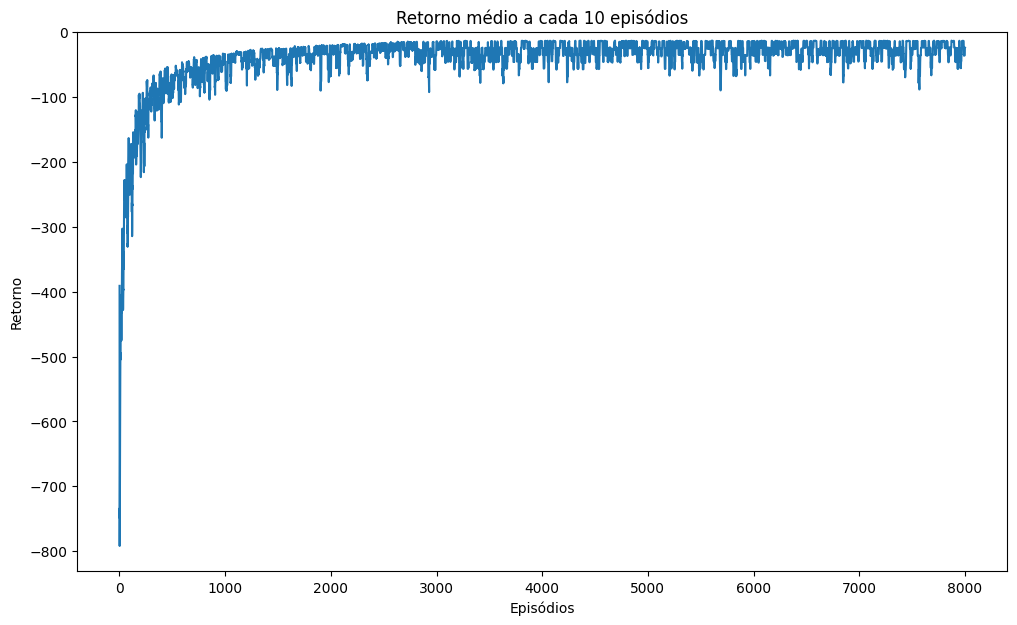

In [10]:
# Mostra um gráfico de episódios x retornos não descontados
plot_result(rewards1, r_max)

In [11]:
# Avalia, usando a tabela de forma greedy
evaluate_qtable_policy(env, qtable1, num_episodes=10, epsilon=0.0, verbose=True);

Episódio 1: -13.0
Episódio 2: -13.0
Episódio 3: -13.0
Episódio 4: -13.0
Episódio 5: -13.0
Episódio 6: -13.0
Episódio 7: -13.0
Episódio 8: -13.0
Episódio 9: -13.0
Episódio 10: -13.0
Retorno médio (por episódio): -13.00, episódios: 10, total de passos: 130


In [12]:
# Salva vídeos, usando a tabela de forma greedy
record_video_qtable(ENV_NAME, qtable1, episodes=2, folder='videos/', prefix='qlearning', epsilon=0.0)

In [13]:
# Exibe o vídeo gravado
display_videos_from_path('videos/', prefix='qlearning')

## 2. SARSA

O **SARSA** é um algoritmo semelhante ao Q-Learning. Porém, ele usa um valor de $V(s')$ baseado na próxima ação ($a'$) realmente escolhida.

Em outras palavras, o Q-Learning:
- usa os dados $(s,a,r,s')$ para fazer uma atualização no $Q(s,a)$
- assume que o valor do próximo estado é (guloso) baseado na melhor ação possível: $V(s') = max_{a'}{Q(s', a')}$

Porém, o SARSA:
- usa os dados $(s,a,r,s',a')$ para fazer uma atualização no $Q(s,a)$
- assume que o valor do próximo estado é o resultado da verdadeira próxima ação $a'$: $V(s') = Q(s', a')$

Crie o código do SARSA abaixo, com base no código do Q-Learning. Dicas:
- para atualizar o $Q$, você precisa desta 4 variáveis coerentemente mantidas: `state, action, next_state, next_action`
- escolha a "próxima ação" imediatamente após cada passo (e logo após o reset) e antes da atualização do $Q$

In [14]:
# Algoritmo SARSA
# Atenção: os espaços de estados e de ações precisam ser discretos, dados por valores inteiros
def run_sarsa(env, episodes, lr=0.1, gamma=0.95, epsilon=0.1):
    assert isinstance(env.observation_space, gym.spaces.Discrete)
    assert isinstance(env.action_space, gym.spaces.Discrete)

    num_actions = env.action_space.n

    # inicializa a tabela Q com valores aleatórios de -1.0 a 0.0
    # usar o estado como índice das linhas e a ação como índice das colunas
    Q = np.zeros(shape = (env.observation_space.n, num_actions))

    # para cada episódio, guarda sua soma de recompensas (retorno não-descontado)
    all_episode_rewards = []

    # loop principal
    for i in range(episodes):
        done = False
        sum_rewards, reward = 0, 0

        state, _ = env.reset()
        action = epsilon_greedy(Q, state, epsilon)

        while not done:
            next_state, reward, terminated, trunc, _ = env.step(action)
            done = terminated or trunc

            next_action = epsilon_greedy(Q, next_state, epsilon)

            if terminated:
                # para estados terminais
                V_next_state = 0
            else:
                # para estados não-terminais
                V_next_state = Q[next_state, next_action]

            # atualiza a Q-table
            # delta = (estimativa usando a nova recompensa) - estimativa antiga
            delta = (reward + gamma * V_next_state) - Q[state,action]
            Q[state,action] = Q[state,action] + lr * delta

            sum_rewards += reward
            state = next_state
            action = next_action

        all_episode_rewards.append(sum_rewards)

        # a cada 100 episódios, imprime informação sobre o progresso
        if VERBOSE and ((i+1) % 100 == 0):
            avg_reward = np.mean(all_episode_rewards[-100:])
            print(f"Episode {i+1} Average Reward (last 100): {avg_reward:.3f}")

    return all_episode_rewards, Q

Se não conseguir implementar, descomente o código abaixo para prosseguir:

In [15]:
#from cap05.qlearning_sarsa import run_sarsa

In [16]:
#ENV_NAME, r_max = "Taxi-v3", 10
ENV_NAME, r_max = "CliffWalking-v0", 0

EPISODES = 8_000
LR = 0.05
GAMMA = 0.95
EPSILON = 0.05

env = gym.make(ENV_NAME, max_episode_steps=500)

# Roda o algoritmo SARSA
rewards2, qtable2 = run_sarsa(env, EPISODES, LR, GAMMA, EPSILON)
clear_output()

print("Últimos resultados: media =", np.mean(rewards2[-20:]), ", desvio padrao =", np.std(rewards2[-20:]))

Últimos resultados: media = -21.0 , desvio padrao = 21.612496385193452


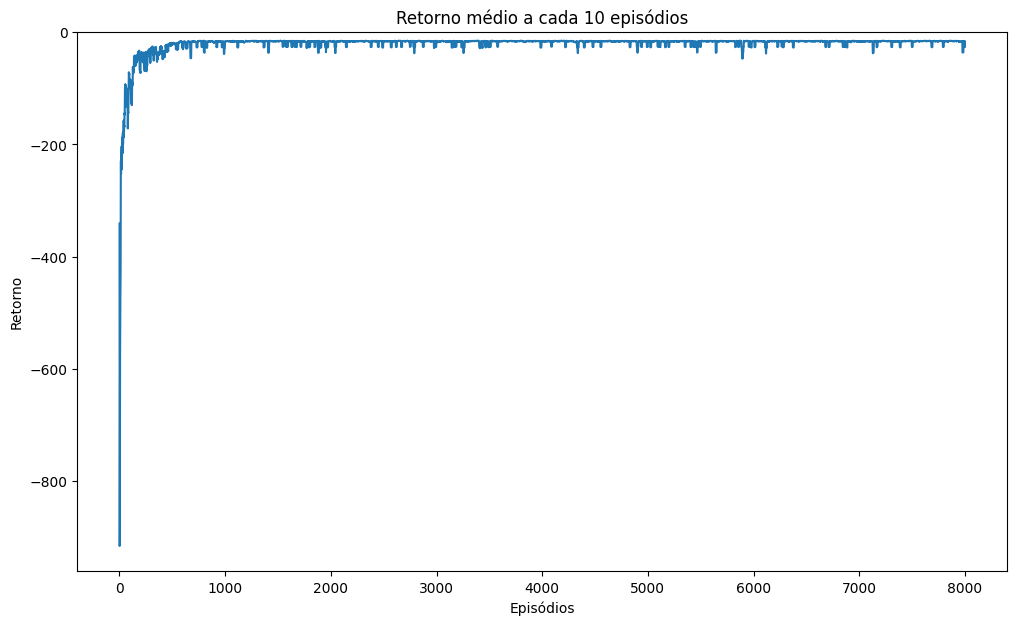

In [17]:
plot_result(rewards2, r_max)

In [18]:
evaluate_qtable_policy(env, qtable2, num_episodes=10, epsilon=0.0, verbose=True);

Episódio 1: -15.0
Episódio 2: -15.0
Episódio 3: -15.0
Episódio 4: -15.0
Episódio 5: -15.0
Episódio 6: -15.0
Episódio 7: -15.0
Episódio 8: -15.0
Episódio 9: -15.0
Episódio 10: -15.0
Retorno médio (por episódio): -15.00, episódios: 10, total de passos: 150


In [19]:
record_video_qtable(ENV_NAME, qtable2, episodes=2, folder='videos/', prefix='sarsa', epsilon=0.0)
#clear_output()

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [20]:
display_videos_from_path('videos/', prefix='sarsa')

## 3. Expected-SARSA

O Expected-SARSA tem semelhanças com os dois algoritmos vistos antes:
- usa os dados $(s,a,r,s')$ para fazer uma atualização no $Q(s,a)$
- assume que o valor do próximo estado é o valor médio, com base nas probabilidades dadas pela política:
   $$V(s') = \displaystyle\sum_{a'} \pi(a'|s') \times Q(s',a')$$

Para implementá-lo, precisamos das probabilidades da política realizar cada ação.

A função abaixo retorna as probabilidades de cada ação na política *epsilon-greedy*:

In [21]:
def epsilon_greedy_probs(Q, state, num_actions, epsilon):
    # lista com a probabilidade que todas as ações têm de ser escolhidas nas decisões exploratórias (não-gulosas)
    probs = [ (epsilon / num_actions) ] * num_actions

    # adiciona a probabilidade para a ação 'greedy'
    # em caso de empate, só o menor índice é considerado
    # (isso é coerente com a implementação da função epsilon_greedy())
    greedy_action = np.argmax(Q[state])
    probs[greedy_action] += (1.0 - epsilon)

    return probs

In [22]:
# Algoritmo Expected-SARSA
def run_expected_sarsa(env, episodes, lr=0.1, gamma=0.95, epsilon=0.1):
    num_actions = env.action_space.n

    # inicializa a tabela Q toda com zeros
    # usar o estado como índice das linhas e a ação como índice das colunas
    Q = np.zeros(shape = (env.observation_space.n, num_actions))

    # para cada episódio, guarda sua soma de recompensas (retorno não-descontado)
    sum_rewards_per_ep = []

    # loop principal
    for i in range(episodes):
        done = False
        sum_rewards, reward = 0, 0

        state, _ = env.reset()

        # executa 1 episódio completo, fazendo atualizações na Q-table
        while not done:
            # escolhe a próxima ação -- usa epsilon-greedy
            action = epsilon_greedy(Q, state, epsilon)

            # realiza a ação, ou seja, dá um passo no ambiente
            next_state, reward, terminated, trunc, _ = env.step(action)
            done = terminated or trunc

            if terminated:
                # para estados terminais
                V_next_state = 0
            else:
                # para estados não-terminais -- valor esperado
                p_next_actions = epsilon_greedy_probs(Q, next_state, num_actions, epsilon)
                V_next_state = np.sum( np.asarray(p_next_actions) * Q[next_state] )

            # atualiza a Q-table
            # delta = (estimativa usando a nova recompensa) - estimativa antiga
            delta = (reward + gamma * V_next_state) - Q[state,action]
            Q[state,action] = Q[state,action] + lr * delta

            sum_rewards += reward
            state = next_state

        # salva o retorno do episódio que encerrou
        sum_rewards_per_ep.append(sum_rewards)

        # a cada 100 episódios, imprime informação sobre o progresso
        if VERBOSE and ((i+1) % 100 == 0):
            avg_reward = np.mean(sum_rewards_per_ep[-100:])
            print(f"Episode {i+1} Average Reward (last 100): {avg_reward:.3f}")

    return sum_rewards_per_ep, Q


In [23]:
#ENV_NAME, r_max = "Taxi-v3", 10
ENV_NAME, r_max = "CliffWalking-v0", 0

EPISODES = 8_000
LR = 0.2
GAMMA = 0.95
EPSILON = 0.1

env = gym.make(ENV_NAME, max_episode_steps=500)

rewards3, qtable3 = run_expected_sarsa(env, EPISODES, LR, GAMMA, EPSILON)
clear_output()

print("Últimos resultados: media =", np.mean(rewards3[-20:]), ", desvio padrao =", np.std(rewards3[-20:]))

Últimos resultados: media = -16.85 , desvio padrao = 1.930673457630782


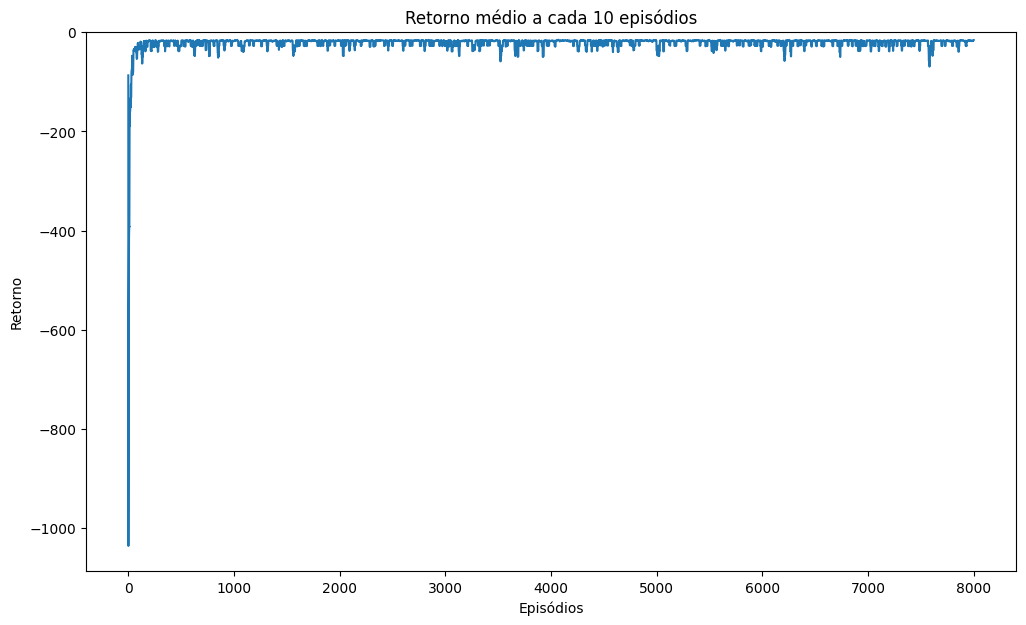

In [24]:
plot_result(rewards3, r_max)

In [25]:
evaluate_qtable_policy(env, qtable3, num_episodes=10, epsilon=0.0, verbose=True);

Episódio 1: -15.0
Episódio 2: -15.0
Episódio 3: -15.0
Episódio 4: -15.0
Episódio 5: -15.0
Episódio 6: -15.0
Episódio 7: -15.0
Episódio 8: -15.0
Episódio 9: -15.0
Episódio 10: -15.0
Retorno médio (por episódio): -15.00, episódios: 10, total de passos: 150


In [26]:
record_video_qtable(ENV_NAME, qtable3, episodes=2, folder='videos/', prefix='expec-sarsa', epsilon=0.0)
clear_output()

In [27]:
display_videos_from_path('videos/', prefix='expec-sarsa')

In [28]:
## 4. Experimentos

In [29]:
# parâmetros para todos os algoritmos (não é o ideal)
LR = 0.1
GAMMA = 0.95
EPSILON = 0.05

# silencia os algoritmos
VERBOSE = False

# repetições de cada algoritmo
RUNS = 5

# para carregar automaticamente os resultados de simulações já executadas
AUTO_LOAD = False

### Taxi-v3 (discreto)

In [30]:
environment = gym.make("Taxi-v3")
NUM_EPISODES = 5_000

results_t = []

results_t.append( repeated_exec(RUNS, f"Q-Learning", run_qlearning, environment, NUM_EPISODES, LR, GAMMA, EPSILON, auto_load=AUTO_LOAD) )
clear_output()
results_t.append( repeated_exec(RUNS, f"Sarsa", run_sarsa, environment, NUM_EPISODES, LR, GAMMA, EPSILON, auto_load=AUTO_LOAD) )
clear_output()
results_t.append( repeated_exec(RUNS, f"Exp-Sarsa", run_expected_sarsa, environment, NUM_EPISODES, LR, GAMMA, EPSILON, auto_load=AUTO_LOAD) )
clear_output()

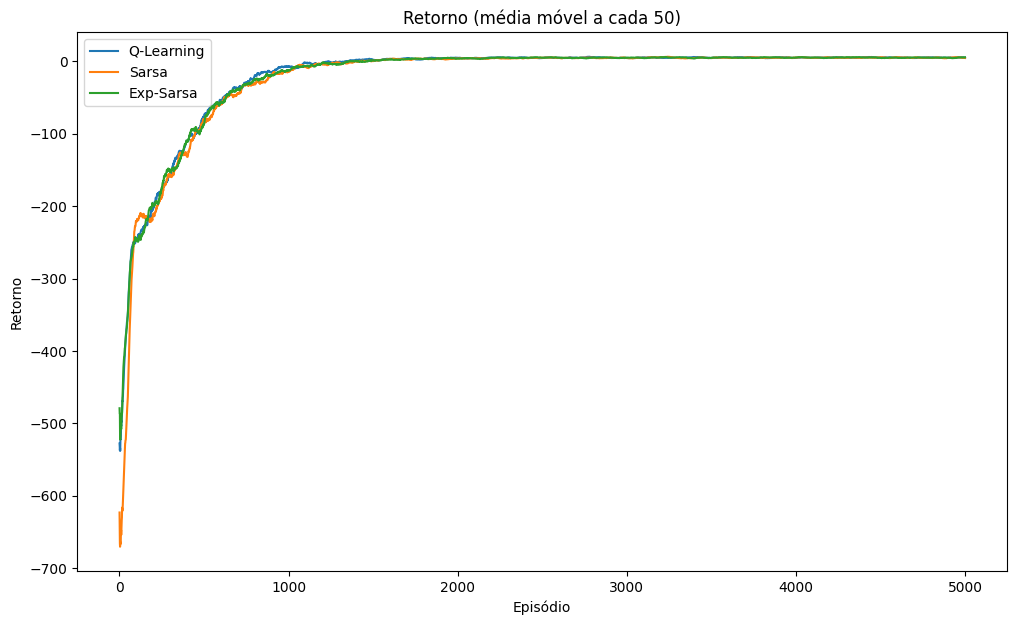

In [31]:
plot_multiple_results(results_t, x_log_scale=False, window=50)

### FrozenLake-v1

In [32]:
environment = gym.make("FrozenLake-v1")
NUM_EPISODES = 8_000

results_f = []

results_f.append( repeated_exec(RUNS, f"Q-Learning", run_qlearning, environment, NUM_EPISODES, LR, GAMMA, EPSILON, auto_load=AUTO_LOAD) )
clear_output()
results_f.append( repeated_exec(RUNS, f"Sarsa", run_sarsa, environment, NUM_EPISODES, LR, GAMMA, EPSILON, auto_load=AUTO_LOAD) )
clear_output()
results_f.append( repeated_exec(RUNS, f"Exp-Sarsa", run_expected_sarsa, environment, NUM_EPISODES, LR, GAMMA, EPSILON, auto_load=AUTO_LOAD) )
clear_output()

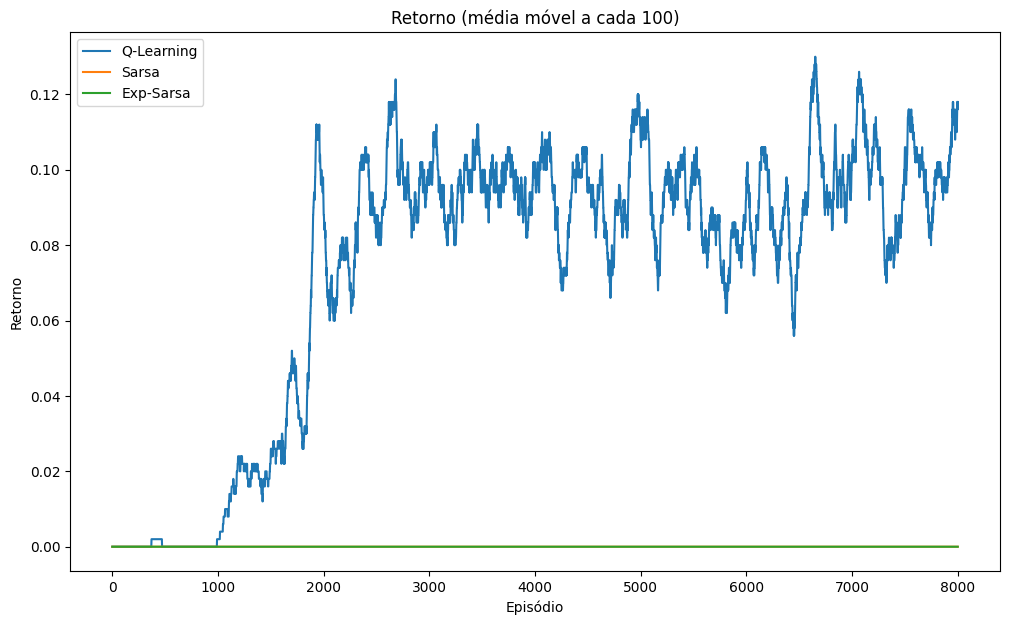

In [33]:
plot_multiple_results(results_f, x_log_scale=False, window=100)

### Cliff Walking

In [34]:
environment = gym.make("CliffWalking-v0", max_episode_steps=100)
NUM_EPISODES = 1_000

results_c = []

results_c.append( repeated_exec(RUNS, f"Q-Learning", run_qlearning, environment, NUM_EPISODES, LR, GAMMA, EPSILON, auto_load=AUTO_LOAD) )
clear_output()
results_c.append( repeated_exec(RUNS, f"Sarsa", run_sarsa, environment, NUM_EPISODES, LR, GAMMA, EPSILON, auto_load=AUTO_LOAD) )
clear_output()
results_c.append( repeated_exec(RUNS, f"Exp-Sarsa", run_expected_sarsa, environment, NUM_EPISODES, LR, GAMMA, EPSILON, auto_load=AUTO_LOAD) )
clear_output()

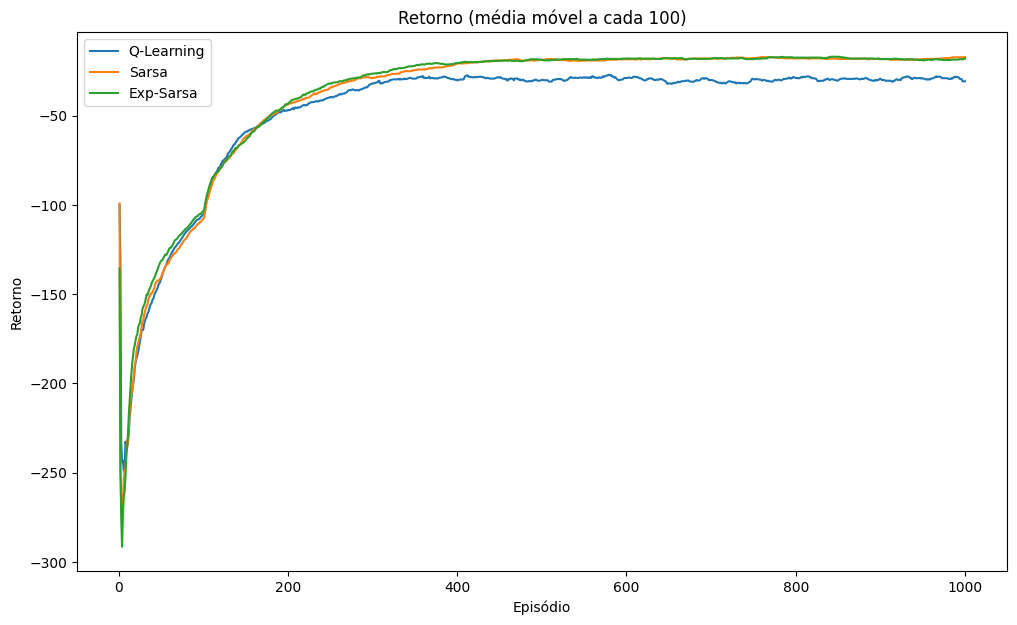

In [35]:
plot_multiple_results(results_c, x_log_scale=False, window=100)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pablo-sampaio/rl_facil/blob/main/cap06/cap06-main.ipynb)

## Capítulo 6 - SARSA de _n_ passos / Tratando Estados Contínuos


## Configurações Iniciais

In [36]:
import gymnasium as gym
from gymnasium.wrappers import TimeLimit

import numpy as np

from cap06.nstep_sarsa import run_nstep_sarsa

from envs import RacetrackEnv
from envs.wrappers import ObservationDiscretizerWrapper


## 1 - SARSA de n Passos

É uma extensão do SARSA que usa uma sequência de de *n* passos (ou seja, com *n* ações realizadas no ambiente) como entrada para cada atualização da estimativa do $Q(s,a)$.

Com **$n=1$**, ele estima $Q(s,a)$ igual ao *SARSA*:
- usa esta experiência: $s, a, r_1, s_1, a_1$
- calcula a nova estimativa de $Q(s,a)$ assim (para estados não-terminais):
$$Q_{target} = r_1 + \gamma . Q(s_1,a_1)$$
- note que apenas 1 ação foi realizada ($a$) e apenas 1 recompensa foi recebida ($r_1$)
- observe que a última ação ($a_1$) foi escolhida, mas não foi realizada no ambiente

Com **$n=2$**, para estimar $Q(s,a)$, ele:
- usa esta experiência: $s, a, r_1, s_1, a_1, r_2, s_2, a_2$
- calcula a nova estimativa de $Q(s,a)$ assim:
$$Q_{target} = r_1 + \gamma .r_2 + \gamma^2 . Q(s_2,a_2)$$
- esta é uma estimativa mais precisa, que usa os dados de *duas* recompensas reais

Para **$n$ qualquer**:
- experiência: $s, a, r_1, s_1, a_1, r_2, s_2, a_2, s_3, \cdots, r_n, s_n, a_n$
- nova estimativa:
$$Q_{target} = r_1 + \gamma .r_2 + \gamma^2 . r_2 + \cdots + \gamma^n . Q(s_n,a_n)$$

O $n$ será um parâmetro do algoritmo.

O código é mais complexo do que dos algoritmos de 1 passo. Veja o arquivo `cap06/nstep_sarsa.py` para conhecer os detalhes.

Abaixo, vamos importar e usar aquela implementação para fazer um experimento:

In [37]:
# para ambientes gymnasium
#ENV_NAME, r_max = "Taxi-v3", 10
#ENV_NAME, r_max = "CliffWalking-v0", 0
#ENV_NAME, r_max = "FrozenLake-v1", 0
ENV_NAME, r_max = "RaceTrack-v0", 0

env = gym.make(ENV_NAME)

# para ambientes instanciados diretamente
# atenção: vale a pena aplicar um TimeLimit
#env = RacetrackEnv()
#r_max = 0

EPISODES = 5_000
LR = 0.1
GAMMA = 0.95
EPSILON = 0.1
NSTEPS = 5

# Roda o algoritmo "n-step SARSA"
rewards1, qtable1 = run_nstep_sarsa(env, EPISODES, NSTEPS, LR, GAMMA, EPSILON, verbose=True)
print("Últimos resultados: media =", np.mean(rewards1[-20:]), ", desvio padrao =", np.std(rewards1[-20:]))

Episode 100 Average Reward (last 100): -116.460
Episode 200 Average Reward (last 100): -102.660
Episode 300 Average Reward (last 100): -101.590
Episode 400 Average Reward (last 100): -101.450
Episode 500 Average Reward (last 100): -89.840
Episode 600 Average Reward (last 100): -76.270
Episode 700 Average Reward (last 100): -75.910
Episode 800 Average Reward (last 100): -74.900
Episode 900 Average Reward (last 100): -68.110
Episode 1000 Average Reward (last 100): -63.240
Episode 1100 Average Reward (last 100): -72.520
Episode 1200 Average Reward (last 100): -56.210
Episode 1300 Average Reward (last 100): -61.000
Episode 1400 Average Reward (last 100): -60.250
Episode 1500 Average Reward (last 100): -54.520
Episode 1600 Average Reward (last 100): -53.850
Episode 1700 Average Reward (last 100): -49.040
Episode 1800 Average Reward (last 100): -44.080
Episode 1900 Average Reward (last 100): -42.650
Episode 2000 Average Reward (last 100): -46.540
Episode 2100 Average Reward (last 100): -46.7

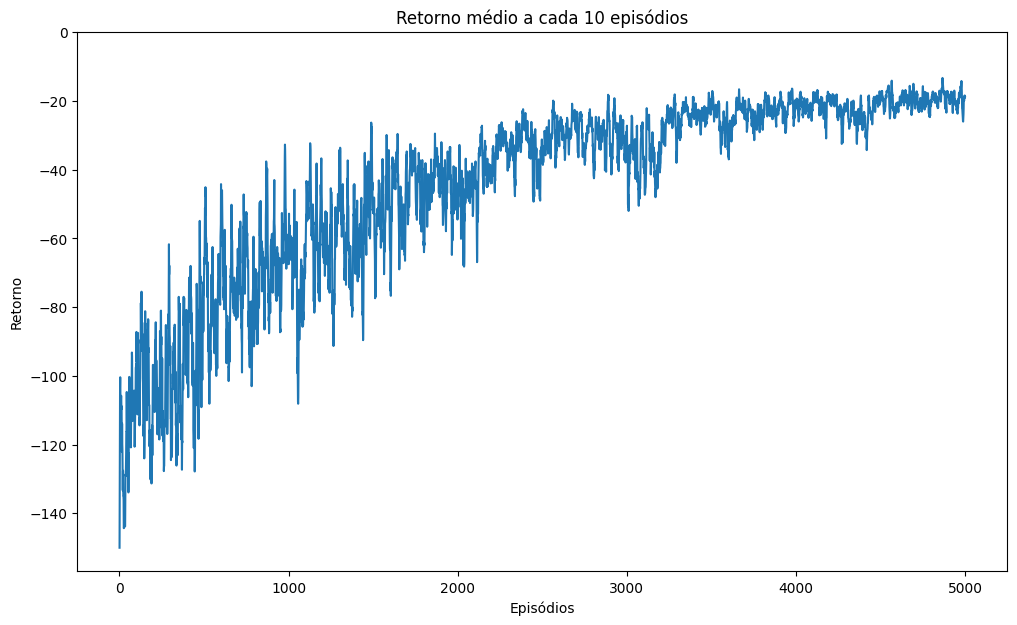

In [38]:
# Mostra um gráfico de episódios x retornos não descontados
plot_result(rewards1, r_max, None)

In [39]:
evaluate_qtable_policy(env, qtable1, 10, epsilon=0.1, verbose=True);

Episódio 1: -16.0
Episódio 2: -12.0
Episódio 3: -23.0
Episódio 4: -18.0
Episódio 5: -13.0
Episódio 6: -12.0
Episódio 7: -15.0
Episódio 8: -12.0
Episódio 9: -18.0
Episódio 10: -14.0
Retorno médio (por episódio): -15.30, episódios: 10, total de passos: 163


In [40]:
# atenção: precisa passar a ID do ambiente no gymnasium ou instanciar diretamente um novo ambiente com o render_mode "rgb_array"
record_video_qtable(ENV_NAME, qtable1, episodes=3, folder='videos/', prefix='nstep-discrete')
#record_video_qtable(RacetrackEnv(render_mode="rgb_array"), qtable1, episodes=3, folder='videos/', prefix='nstep-discrete')

In [41]:
display_videos_from_path('./videos', prefix='nstep-discrete')

A seguir, vamos rodar alguns experimentos variando a quantidade de passos:

In [42]:
RUNS = 3
results1 = []
for nstep in [1, 2, 3]:
    results1.append( repeated_exec(RUNS, f"{nstep}-step SARSA (LR={LR})", run_nstep_sarsa, env, EPISODES, nstep, LR) )
    clear_output()

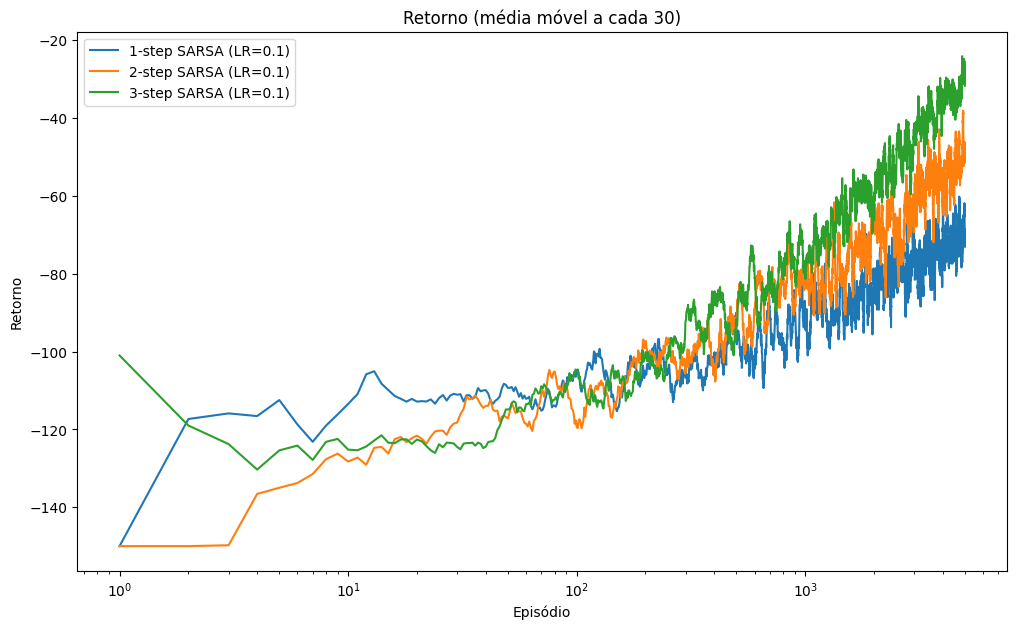

In [43]:
plot_multiple_results(results1, window=30, x_log_scale=True)

## 2 - Lidando com Estados Contínuos

Vamos usar os mesmos algoritmos de antes, baseados em Q-Table, para lidar com ambientes de estados contínuos.

Para isso, vamos usar um *wrapper* que discretiza os estados desses ambientes.

Primeiramente, vamos analisar, abaixo, o espaço de estados de um ambiente contínuo:

In [44]:
ENV_NAME = "CartPole-v1"
r_max_plot = 200

env2a = gym.make(ENV_NAME)

# vamos ver como é um estado deste ambiente?
print("Espaço de estados/observações: ", env2a.observation_space)
print("  - formato: ", env2a.observation_space.shape)
print("  - exemplo: ", env2a.reset())

Espaço de estados/observações:  Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
  - formato:  (4,)
  - exemplo:  (array([ 0.03673087, -0.00898243,  0.02897304,  0.04834074], dtype=float32), {})


Abaixo, nós encapsulamos o ambiente contínuo em um wrapper para discretizá-lo.

Os parâmetros indicam quantos valores discretos foram usados para representar cada uma das dimensões do estado.

Como resultado, o espaço de estados torna-se do tipo `Discrete`, o que indica que cada "estado" é representado como um único número inteiro.

In [45]:
# Encapsula o ambiente em nosso wrapper
# atenção para o parâmetro BINS: deve ter um valor para cada componente do estado
BINS = [5, 30, 30, 30]
env2b = ObservationDiscretizerWrapper(env2a, BINS)

env2b.observation_space

/content/rl_facil/envs/wrappers.py:57: RuntimeWarning: overflow encountered in scalar multiply
  min_value = env_space.low[i] if not np.isneginf(env_space.low[i]) else 2*np.finfo(np.float64).min
/usr/local/lib/python3.11/dist-packages/numpy/core/function_base.py:158: RuntimeWarning: invalid value encountered in multiply
  y *= step
/usr/local/lib/python3.11/dist-packages/numpy/core/function_base.py:168: RuntimeWarning: invalid value encountered in add
  y += start


Discrete(135000)

Agora, podemos rodar treinamentos com quaisquer dos algoritmos que temos visto. Vamos rodar o *SARSA de n passos*:

In [46]:
EPISODES = 5_000
LR = 0.2
GAMMA = 0.95
EPSILON = 0.1
NSTEPS = 4

rewards2, qtable2 = run_nstep_sarsa(env2b, EPISODES, NSTEPS, LR, GAMMA, EPSILON, verbose=True)

print("Últimos resultados: media =", np.mean(rewards2[-20:]), ", desvio padrao =", np.std(rewards2[-20:]))

Episode 100 Average Reward (last 100): 14.110
Episode 200 Average Reward (last 100): 24.390
Episode 300 Average Reward (last 100): 33.950
Episode 400 Average Reward (last 100): 34.940
Episode 500 Average Reward (last 100): 36.670
Episode 600 Average Reward (last 100): 33.640
Episode 700 Average Reward (last 100): 36.920
Episode 800 Average Reward (last 100): 34.620
Episode 900 Average Reward (last 100): 37.770
Episode 1000 Average Reward (last 100): 36.720
Episode 1100 Average Reward (last 100): 35.730
Episode 1200 Average Reward (last 100): 36.540
Episode 1300 Average Reward (last 100): 37.050
Episode 1400 Average Reward (last 100): 38.880
Episode 1500 Average Reward (last 100): 31.080
Episode 1600 Average Reward (last 100): 32.090
Episode 1700 Average Reward (last 100): 34.720
Episode 1800 Average Reward (last 100): 35.920
Episode 1900 Average Reward (last 100): 38.190
Episode 2000 Average Reward (last 100): 32.080
Episode 2100 Average Reward (last 100): 35.270
Episode 2200 Average R

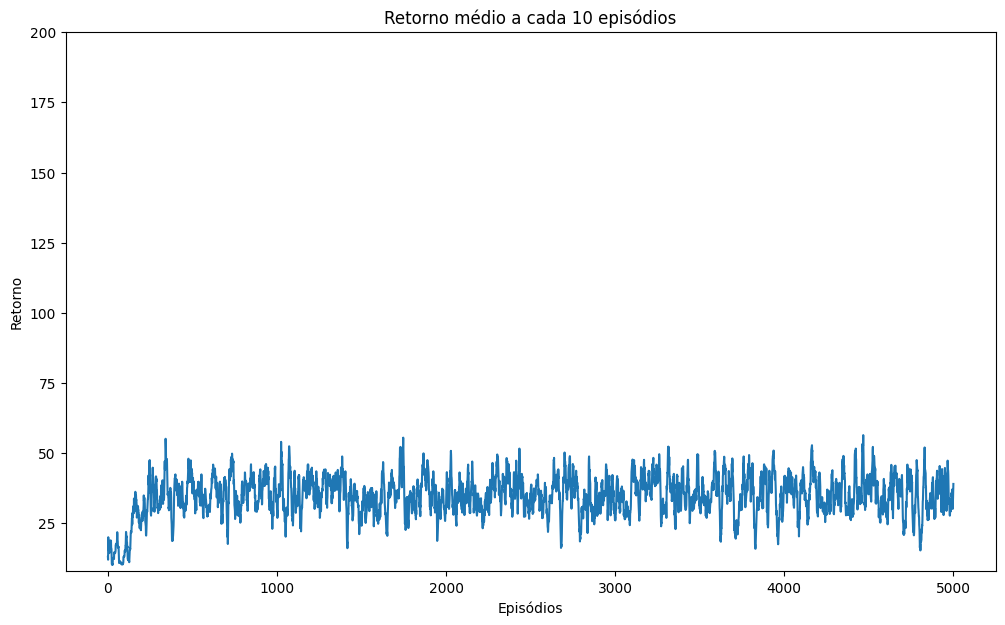

In [47]:
# Gera um gráfico de episódios x retornos (não descontados)
plot_result(rewards2, r_max_plot)

In [48]:
# Faz alguns testes, usando a tabela de forma greedy
evaluate_qtable_policy(env2b, qtable2, 10, 0.0, verbose=True)

Episódio 1: 30.0
Episódio 2: 43.0
Episódio 3: 28.0
Episódio 4: 32.0
Episódio 5: 42.0
Episódio 6: 41.0
Episódio 7: 28.0
Episódio 8: 29.0
Episódio 9: 42.0
Episódio 10: 41.0
Retorno médio (por episódio): 35.60, episódios: 10, total de passos: 356


(35.6, [30.0, 43.0, 28.0, 32.0, 42.0, 41.0, 28.0, 29.0, 42.0, 41.0])

In [49]:
# Salva vídeo
# Atenção: é recomendado criar nova instância do ambiente e do wrapper!
env_test = gym.make(ENV_NAME, render_mode="rgb_array")
env_test = ObservationDiscretizerWrapper(env_test, BINS)
record_video_qtable(env_test, qtable2, episodes=3, folder='videos/', prefix='nstep-cartpole')

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [50]:
# Exibe o video
display_videos_from_path('./videos', prefix='nstep-cartpole')

## 3 - Otimizando Parâmetros

Vamos usar a biblioteca *Optuna* para otimizar (hiper-)parâmetros dos algoritmos de treinamento.

In [51]:
import optuna

ModuleNotFoundError: No module named 'optuna'

### 3.1 - Ambiente Discreto

Este é o caso mais simples, porque não precisamos aplicar nenhum wrapper.

Primeiro, você precisa fazer uma função que receber um parâmetro do tipo `Trial` (definido no optuna) e retorna uma medida de desempenho.

Dentro da função, você usa o objeto *trial* para pedir "sugestões" de valores para os hiper-parâmetros do seu algoritmo.

In [ ]:
def train_nstep_sarsa_racetrack(trial : optuna.Trial):
    # chama os métodos do "trial" (tentativa) para sugerir valores para os parâmetros
    eps    = trial.suggest_float('epsilon', 0.01, 0.2)
    gamma  = trial.suggest_float('gamma', 0.90, 1.00)
    lr     = trial.suggest_float('lr', 0.001, 1.0, log=True) # sugere na escala log (maior chance de escolher valor menor)
    nsteps = trial.suggest_int('nsteps', 1, 16)

    # outra opção trial.suggest_categorical('param', ['value1', 'value2'])

    print(f"\nTRIAL #{trial.number}: {trial.params}")

    # cria o ambiente Racetrack, mas insere-o em um wrapper para limitar o tamanho do episódio
    env = gym.make("RaceTrack-v0")

    # roda o algoritmo e recebe os retornos não-descontados
    (returns, _) = run_nstep_sarsa(env, 3000, nsteps, lr=lr, epsilon=eps, gamma=gamma, verbose=False)

    # média dos retornos dos últimos 100 episódios
    return sum(returns[-100:])/100


Depois, você cria um "study" do Optuna e manda otimizar sua função, indicando quantas tentativas (trials) ele vai fazer -- ou seja, quantas vezes a sua função vai ser executada.

In [ ]:
study1 = optuna.create_study(direction='maximize',
                        storage='sqlite:///optuna_cap06.db',
                        study_name='nstep_sarsa_racetrack',
                        load_if_exists=True)

# maximiza o valor de retorno de train_exp_sarsa, rodando "n_trials" vezes
# o parâmetro "n_jobs" indica a quantidade de CPUs a serem usadas (-1 para usar todas)
study1.optimize(train_nstep_sarsa_racetrack, n_trials=20, n_jobs=2)

In [ ]:
print("MELHORES PARÂMETROS:")
print(study1.best_params)

### 3.2 - Ambiente Contínuo

Neste caso, nós aplicamos o wrapper, que tem novos parâmetros (quantidade de "bins" por valor do estado).

O wrapper é considerado parte da solução e, por isso, os bins são também parâmetros a serem otimizados.

In [ ]:
def train_nstep_sarsa_cartpole(trial : optuna.Trial):
    # para os parâmetros do algoritmo
    eps    = trial.suggest_float('epsilon', 0.01, 0.2)
    #gamma  = trial.suggest_float('gamma', 0.90, 1.00) # comentei, para deixar menos parâmetros
    lr     = trial.suggest_float('lr', 0.001, 1.0, log=True) # sugere na escala log (maior chance de escolher valor menor)
    nsteps = trial.suggest_int('nsteps', 1, 16)

    # para os parâmetros da discretização
    bins1 = trial.suggest_int('bins1', 10, 100, step=10)
    bins2 = trial.suggest_int('bins2', 10, 100, step=10)
    bins3 = trial.suggest_int('bins3', 10, 100, step=10)
    bins4 = trial.suggest_int('bins4', 10, 100, step=10)

    all_bins = [bins1, bins2, bins3, bins4]

    print(f"\nTRIAL #{trial.number}: {trial.params}")

    # cria o ambiente e o coloca no wrapper
    env = gym.make("CartPole-v1")
    env_wrapper = ObservationDiscretizerWrapper(env, all_bins)

    # roda o algoritmo, recebendo os retornos não-descontados
    (returns, _) = run_nstep_sarsa(env_wrapper, 4000, nsteps, lr=lr, epsilon=eps, gamma=1.0, verbose=False)

    # média dos retornos dos últimos 100 episódios
    return sum(returns[-100:])/100


In [ ]:
study2 = optuna.create_study(direction='maximize',
                        storage='sqlite:///optuna_cap06.db',
                        study_name='nstep_sarsa_cartpole',
                        load_if_exists=True)

# maximiza o valor de retorno de train_expsarsa_continuous, rodando "n_trials" vezes
study2.optimize(train_nstep_sarsa_cartpole, n_trials=20, n_jobs=2)

In [ ]:
print("MELHORES PARÂMETROS:")
print(study2.best_params)

### 3.3 - Dicas

Seguem algumas dicas para usar o optuna:

1. É importante rodar muitos trials (por volta de 100), para resultados mais confiáveis.
1. Dentro da função, você deve mandar treinar por uma quantidade intermediária de iterações (=episódios, nos algoritmos):
   - Deve ser relativamente pequena, para não demorar muito tempo rodando.
   - Deve ser alta o suficiente para dar tempo chegar em um resultado.
1. Também ajuda a obter bons resultados logo se você reduzir a quantidade de valores possíveis para cada parâmetro a ser otimizado.
   - Para `float`, tente restringir os valores a uma faixa de valores úteis. Exemplo: para o `gamma`, coloque como mínimo `0.5` ou outro valor maior.
   - Para `int`, coloque algum passo (parâmetro `step`) maior que 1, se for adequado. Exemplo: fiz isso com os bins, no exemplo acima.
1. Para parâmetros `float` que reconhecidamente são melhores com baixos valores, faça `'log=True'`, para explorar mais a região dos valores menores.
   - Exemplo: fiz isso com as taxas de aprendizagem
1. Uma forma mais confiável (porém mais lenta) de avaliar um algoritmo é, dentro da função a ser otimizada, fazer várias execuções da função de treinamento e retornar a média ou a mediana
1. Quando você fizer *qualquer* alteração dentro da função a ser otimizada, reinicie o estudo de uma dessas formas:
   - Apague o arquivo ".db"
   - Ou mude o nome do estudo (parâmetro `study_name`)
1. Se você não alterar nada da função a ser otimizada, você pode rodar novamente o método `.optimize()` com o mesmo `study_name` com segurança. Neste caso, ele irá carregar os dados dos *trials* anteriores e irá rodar novos trials na quantidade indicada por `n_trials`.
1. Veja a quantidade de processadores da sua máquina e ajuste adequadamente o `n_jobs`, ou defina-o como -1 para usar todos eles.
   - Se usar mais de 1 processador, evite interromper de forma "forçada" a execução do método `optimize()`, pois interromper pode resultar em comportamentos estranhos (principalmente em notebooks Jupyter).


## 4 - Experimentos Completos

Agora que você descobriu bons parâmetros, que tal rodar um treinamento mais longo com o seu algoritmo?

Para cada ambiente, comparar os parâmetros default com os parâmetros otimizados.


### Racetrack

In [ ]:
#env_race = TimeLimit(RacetrackEnv(), 500)
env_race = gym.make("RaceTrack-v0")
NUM_EPISODES = 12_000
RUNS = 3

results = []

results.append( repeated_exec(RUNS, f"SARSA n-passos (default)", run_nstep_sarsa, env_race, NUM_EPISODES) )
#clear_output()

results.append( repeated_exec(RUNS, f"SARSA n-passos (otimizado)", run_nstep_sarsa, env_race, NUM_EPISODES, **study1.best_params) )
clear_output()

plot_multiple_results(results, x_log_scale=False)

### CartPole

In [ ]:
env_cart = gym.make("CartPole-v1")
NUM_EPISODES = 12_000
RUNS = 3

results = []

wrapped_env_cart = ObservationDiscretizerWrapper(env_cart, [30,30,30,30])
results.append( repeated_exec(RUNS, f"SARSA n-passos (default)", run_nstep_sarsa, wrapped_env_cart, NUM_EPISODES, auto_load=True) )
#clear_output()

params = study2.best_params

wrapped_env_cart = ObservationDiscretizerWrapper(env_cart, [ params['bins1'], params['bins2'], params['bins3'], params['bins4'] ] )
results.append( repeated_exec(RUNS, f"SARSA n-passos (otimizado)", run_nstep_sarsa, wrapped_env_cart, NUM_EPISODES, epsilon=params['epsilon'], lr=params['lr'], nsteps=params['nsteps'], auto_load=True) )
clear_output()

plot_multiple_results(results, x_log_scale=False)

# Implementação das Variantes do ε

##  Decaimento do ε (Linear e Exponencial)

### Decaimento linear

#### Função

In [62]:
# testando um tipo de decaimento linear do Epsilon
def linear_decay(initial_E=1.0, min_E=0.005, X=1000):
    # X é o numero do passos (limite) para achar o min_E
    k = (initial_E - min_E)/X
    # k é a taxa de decaimento linear: Epsilon inicial - Epsilon minimo/x
    def new_E(t): # t é o passo atual no treinamento
        return max(min_E, initial_E - k * t)
        # primeira vez -> (0.005, 1 - ((1-0.005)/1000) * 1) (0.005 ou 0,999005)
        # segunda vez -> (0.005, 1 - ((1-0.005)/1000) * 2)...
    return new_E

#### Aplicado ao Q-learning

In [82]:
# (Q-learning é off-policy) - usando a mesma func E-greedy e apenas alterando o Q-learning do tópico recapitulações
# ajuste dos parametros -> retira epsilon e coloca e_inicial e min, e X

# Algoritmo Q-learning
# Atenção: os espaços de estados e de ações precisam ser discretos, dados por valores inteiros
def run_qlearning_linear_decay(env, episodes, lr=0.1, gamma=0.95, initial_E=1, min_E=0.005, X=1000):
    assert isinstance(env.observation_space, gym.spaces.Discrete)
    assert isinstance(env.action_space, gym.spaces.Discrete)

    num_actions = env.action_space.n

    # inicializa a tabela Q toda com zeros
    # usar o estado como índice das linhas e a ação como índice das colunas
    Q = np.zeros(shape = (env.observation_space.n, num_actions))

    # para cada episódio, guarda sua soma de recompensas (retorno não-descontado)
    all_episode_rewards = []

    # definindo os variaveis dentro de linear_decay de acordo com o q-learning
    epsilon_linear_decay = linear_decay(initial_E,min_E,X)
    t_steps = 0 # contando passos

    # loop principal
    for i in range(episodes):
        done = False
        sum_rewards, reward = 0, 0

        state, _ = env.reset()

        # executa 1 episódio completo, fazendo atualizações na Q-table
        while not done:
            epsilon = epsilon_linear_decay(t_steps) # retorna o novo epsilon com base no linear decay e passo atual

            # escolhe a próxima ação -- usa epsilon-greedy
            action = epsilon_greedy(Q, state, epsilon)

            # realiza a ação, ou seja, dá um passo no ambiente
            next_state, reward, terminated, trunc, _ = env.step(action)
            done = terminated or trunc

            if terminated:
                # para estados terminais
                V_next_state = 0
            else:
                # para estados não-terminais -- valor máximo (melhor ação)
                V_next_state = np.max(Q[next_state])

            # atualiza a Q-table
            # delta = (estimativa usando a nova recompensa) - estimativa antiga
            delta = (reward + gamma * V_next_state) - Q[state,action]
            Q[state,action] = Q[state,action] + lr * delta

            sum_rewards += reward
            state = next_state

            t_steps += 1 # próximo passo

        all_episode_rewards.append(sum_rewards)

        # a cada 100 episódios, imprime informação sobre o progresso
        if VERBOSE and ((i+1) % 100 == 0):
            avg_reward = np.mean(all_episode_rewards[-100:])
            print(f"Episode {i+1} Average Reward (last 100): {avg_reward:.3f}")

    return all_episode_rewards, Q

#### Aplicado ao SARSA

In [64]:
def run_sarsa_linear_decay(env, episodes, lr=0.1, gamma=0.95, initial_E=1, min_E=0.005, X=1000):
    assert isinstance(env.observation_space, gym.spaces.Discrete)
    assert isinstance(env.action_space, gym.spaces.Discrete)

    num_actions = env.action_space.n

    # Inicializa a tabela Q toda com zeros
    Q = np.zeros(shape=(env.observation_space.n, num_actions))

    # Para cada episódio, guarda sua soma de recompensas (retorno não-descontado)
    all_episode_rewards = []

    # Definindo as variáveis dentro de linear_decay de acordo com o SARSA
    epsilon_linear_decay = linear_decay(initial_E, min_E, X)
    t_steps = 0  # Contando passos

    # Loop principal
    for i in range(episodes):
        done = False
        sum_rewards, reward = 0, 0

        state, _ = env.reset()

        # Escolhe a primeira ação usando epsilon-greedy
        epsilon = epsilon_linear_decay(t_steps)
        action = epsilon_greedy(Q, state, epsilon)

        # Executa 1 episódio completo, fazendo atualizações na Q-table
        while not done:
            # Realiza a ação, ou seja, dá um passo no ambiente
            next_state, reward, terminated, trunc, _ = env.step(action)
            done = terminated or trunc

            # Escolhe a próxima ação usando epsilon-greedy
            next_epsilon = epsilon_linear_decay(t_steps + 1)
            next_action = epsilon_greedy(Q, next_state, next_epsilon)

            if terminated:
                # Para estados terminais
                V_next_state = 0
            else:
                # Para estados não-terminais -- valor da próxima ação (SARSA é on-policy)
                V_next_state = Q[next_state, next_action]

            # Atualiza a Q-table
            # delta = (estimativa usando a nova recompensa) - estimativa antiga
            delta = (reward + gamma * V_next_state) - Q[state, action]
            Q[state, action] = Q[state, action] + lr * delta

            sum_rewards += reward
            state = next_state
            action = next_action  # SARSA usa a próxima ação para a atualização

            t_steps += 1  # Próximo passo

        all_episode_rewards.append(sum_rewards)

        # A cada 100 episódios, imprime informação sobre o progresso
        if VERBOSE and ((i + 1) % 100 == 0):
            avg_reward = np.mean(all_episode_rewards[-100:])
            print(f"Episode {i + 1} Average Reward (last 100): {avg_reward:.3f}")

    return all_episode_rewards, Q

#### Aplicado ao Expected-SARSA

In [65]:
def run_expected_sarsa_linear_decay(env, episodes, lr=0.1, gamma=0.95, initial_E=1, min_E=0.005, X=1000):
    assert isinstance(env.observation_space, gym.spaces.Discrete)
    assert isinstance(env.action_space, gym.spaces.Discrete)

    num_actions = env.action_space.n

    # Inicializa a tabela Q toda com zeros
    Q = np.zeros(shape=(env.observation_space.n, num_actions))

    # Para cada episódio, guarda sua soma de recompensas (retorno não-descontado)
    all_episode_rewards = []

    # Definindo as variáveis dentro de linear_decay de acordo com o Expected-SARSA
    epsilon_linear_decay = linear_decay(initial_E, min_E, X)
    t_steps = 0  # Contando passos

    # Loop principal
    for i in range(episodes):
        done = False
        sum_rewards, reward = 0, 0

        state, _ = env.reset()

        # Escolhe a primeira ação usando epsilon-greedy
        epsilon = epsilon_linear_decay(t_steps)
        action = epsilon_greedy(Q, state, epsilon)

        # Executa 1 episódio completo, fazendo atualizações na Q-table
        while not done:
            # Realiza a ação, ou seja, dá um passo no ambiente
            next_state, reward, terminated, trunc, _ = env.step(action)
            done = terminated or trunc

            # Calcula o valor esperado para o próximo estado
            next_epsilon = epsilon_linear_decay(t_steps + 1)
            expected_value = 0  # Inicializa o valor esperado

            # Calcula a probabilidade de cada ação no próximo estado
            for a in range(num_actions):
                if a == np.argmax(Q[next_state, :]):
                    # Probabilidade de escolher a ação gulosa (1 - epsilon + epsilon/num_actions)
                    prob = (1 - next_epsilon) + (next_epsilon / num_actions)
                else:
                    # Probabilidade de escolher uma ação aleatória (epsilon/num_actions)
                    prob = next_epsilon / num_actions
                expected_value += prob * Q[next_state, a]

            if terminated:
                # Para estados terminais
                V_next_state = 0
            else:
                # Para estados não-terminais -- usa o valor esperado
                V_next_state = expected_value

            # Atualiza a Q-table
            # delta = (estimativa usando a nova recompensa) - estimativa antiga
            delta = (reward + gamma * V_next_state) - Q[state, action]
            Q[state, action] = Q[state, action] + lr * delta

            sum_rewards += reward
            state = next_state
            action = epsilon_greedy(Q, state, next_epsilon)  # Escolhe a próxima ação

            t_steps += 1  # Próximo passo

        all_episode_rewards.append(sum_rewards)

        # A cada 100 episódios, imprime informação sobre o progresso
        if VERBOSE and ((i + 1) % 100 == 0):
            avg_reward = np.mean(all_episode_rewards[-100:])
            print(f"Episode {i + 1} Average Reward (last 100): {avg_reward:.3f}")

    return all_episode_rewards, Q

#### Aplicado ao SARSA de n Passos

In [66]:
def run_nstep_sarsa_linear_decay(env, episodes, n=3, lr=0.1, gamma=0.95, initial_E=1, min_E=0.005, X=1000):
    assert isinstance(env.observation_space, gym.spaces.Discrete)
    assert isinstance(env.action_space, gym.spaces.Discrete)

    num_actions = env.action_space.n

    # Inicializa a tabela Q toda com zeros
    Q = np.zeros(shape=(env.observation_space.n, num_actions))

    # Para cada episódio, guarda sua soma de recompensas (retorno não-descontado)
    all_episode_rewards = []

    # Definindo as variáveis dentro de linear_decay de acordo com o SARSA de n-passos
    epsilon_linear_decay = linear_decay(initial_E, min_E, X)
    t_steps = 0  # Contando passos

    # Loop principal
    for i in range(episodes):
        done = False
        sum_rewards, reward = 0, 0

        state, _ = env.reset()

        # Escolhe a primeira ação usando epsilon-greedy
        epsilon = epsilon_linear_decay(t_steps)
        action = epsilon_greedy(Q, state, epsilon)

        # Listas para armazenar os últimos n estados, ações e recompensas
        states = [state]
        actions = [action]
        rewards = [0]  # A primeira recompensa é 0, pois ainda não houve ação

        # Executa 1 episódio completo, fazendo atualizações na Q-table
        while not done:
            # Realiza a ação, ou seja, dá um passo no ambiente
            next_state, reward, terminated, trunc, _ = env.step(action)
            done = terminated or trunc

            # Escolhe a próxima ação usando epsilon-greedy
            next_epsilon = epsilon_linear_decay(t_steps + 1)
            next_action = epsilon_greedy(Q, next_state, next_epsilon)

            # Armazena o próximo estado, ação e recompensa
            states.append(next_state)
            actions.append(next_action)
            rewards.append(reward)

            # Se já tivermos n passos, atualizamos a Q-table
            if len(states) > n:
                # Calcula o retorno de n-passos
                G = 0
                for j in range(t_steps - n + 1, t_steps + 1):
                    G += (gamma ** (j - (t_steps - n))) * rewards[j]

                # Adiciona o valor do estado final (se não for terminal)
                if not done:
                    G += (gamma ** n) * Q[next_state, next_action]

                # Atualiza a Q-table para o estado e ação de n passos atrás
                update_state = states[t_steps - n]
                update_action = actions[t_steps - n]
                Q[update_state, update_action] += lr * (G - Q[update_state, update_action])

            sum_rewards += reward
            state = next_state
            action = next_action
            t_steps += 1  # Próximo passo

        # Atualiza os últimos n-1 passos que não foram atualizados
        for k in range(max(0, len(states) - n), len(states) - 1):
            G = 0
            for j in range(k, len(states) - 1):
                G += (gamma ** (j - k)) * rewards[j + 1]
            if not done:
                G += (gamma ** (len(states) - 1 - k)) * Q[states[-1], actions[-1]]
            Q[states[k], actions[k]] += lr * (G - Q[states[k], actions[k]])

        all_episode_rewards.append(sum_rewards)

        # A cada 100 episódios, imprime informação sobre o progresso
        if VERBOSE and ((i + 1) % 100 == 0):
            avg_reward = np.mean(all_episode_rewards[-100:])
            print(f"Episode {i + 1} Average Reward (last 100): {avg_reward:.3f}")

    return all_episode_rewards, Q

### Decaimento exponencial

#### Função

In [67]:
import math

def exponential_decay(initial_E=1.0, min_E=0.005, decay_rate=0.001):
    """
    Função de decaimento exponencial para epsilon.

    Parâmetros:
        initial_E (float): Valor inicial de epsilon (epsilon máximo).
        min_E (float): Valor mínimo de epsilon.
        decay_rate (float): Taxa de decaimento (controla a velocidade do decaimento).

    Retorna:
        Uma função que calcula o epsilon para um dado passo t.
    """
    def new_E(t):
        # Decaimento exponencial suave em direção a min_E
        return min_E + (initial_E - min_E) * math.exp(-decay_rate * t)

    return new_E

#### Aplicado ao Q-Learning

In [68]:
import numpy as np
import math
import gym  # Certifique-se de instalar o Gym com: pip install gym

def exponential_decay(initial_E=1.0, min_E=0.005, decay_rate=0.001):
    def new_E(t):
        return min_E + (initial_E - min_E) * math.exp(-decay_rate * t)
    return new_E

def epsilon_greedy(Q, state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(len(Q[state]))  # Exploração
    else:
        best_actions = np.where(Q[state] == np.max(Q[state]))[0]
        return np.random.choice(best_actions)  # Escolhe entre as melhores ações

def run_qlearning_exponential_decay(env, episodes, lr=0.1, gamma=0.95,
                                    initial_E=1.0, min_E=0.005, decay_rate=0.001,
                                    verbose=True):
    # Garantindo que o ambiente é discreto
    assert isinstance(env.observation_space, gym.spaces.Discrete), "Apenas espaços discretos são suportados!"
    assert isinstance(env.action_space, gym.spaces.Discrete), "Apenas ações discretas são suportadas!"

    num_actions = env.action_space.n
    Q = np.zeros((env.observation_space.n, num_actions))
    all_episode_rewards = []
    avg_rewards = []
    epsilon_values = []

    epsilon_decay = exponential_decay(initial_E, min_E, decay_rate)

    for i in range(episodes):
        state, _ = env.reset()  # Ajuste para Gym v0.26+
        done = False
        sum_rewards = 0
        t_steps = 0  # Reseta a cada episódio

        while not done:
            epsilon = epsilon_decay(t_steps)
            action = epsilon_greedy(Q, state, epsilon)

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Atualização Q-Learning
            V_next_state = 0 if done else np.max(Q[next_state])
            Q[state, action] += lr * (reward + gamma * V_next_state - Q[state, action])

            sum_rewards += reward
            state = next_state
            t_steps += 1

        all_episode_rewards.append(sum_rewards)
        avg_rewards.append(np.mean(all_episode_rewards[-100:]))
        epsilon_values.append(epsilon_decay(t_steps))

        if verbose and (i + 1) % 100 == 0:
            print(f"Episode {i + 1}: Avg Reward (last 100): {avg_rewards[-1]:.3f}, Epsilon: {epsilon:.4f}")

    return all_episode_rewards, Q, avg_rewards, epsilon_values

#### Aplicado ao SARSA

In [69]:
import numpy as np
import math
import gym  # Certifique-se de instalar o Gym com: pip install gym

def exponential_decay(initial_E=1.0, min_E=0.005, decay_rate=0.001):
    def new_E(t):
        return min_E + (initial_E - min_E) * math.exp(-decay_rate * t)
    return new_E

def epsilon_greedy(Q, state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(len(Q[state]))  # Exploração
    else:
        best_actions = np.where(Q[state] == np.max(Q[state]))[0]
        return np.random.choice(best_actions)  # Escolha aleatória entre as melhores ações

def run_sarsa_exponential_decay(env, episodes, lr=0.1, gamma=0.95, initial_E=1.0, min_E=0.005, decay_rate=0.001, verbose=True):
    # Garantindo que o ambiente é discreto
    assert isinstance(env.observation_space, gym.spaces.Discrete), "Apenas espaços discretos são suportados!"
    assert isinstance(env.action_space, gym.spaces.Discrete), "Apenas ações discretas são suportadas!"

    num_actions = env.action_space.n
    Q = np.zeros((env.observation_space.n, num_actions))
    all_episode_rewards = []
    avg_rewards = []
    epsilon_values = []

    epsilon_decay = exponential_decay(initial_E, min_E, decay_rate)

    for i in range(episodes):
        state, _ = env.reset()  # Ajuste para Gym v0.26+
        done = False
        sum_rewards = 0
        epsilon = epsilon_decay(i)  # Decaimento baseado no episódio
        epsilon_values.append(epsilon)  # Registrar o valor do epsilon

        # Escolhe a primeira ação usando epsilon-greedy
        action = epsilon_greedy(Q, state, epsilon)

        while not done:
            # Executa a ação no ambiente
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Escolhe a próxima ação usando epsilon-greedy
            next_action = epsilon_greedy(Q, next_state, epsilon)

            # Atualiza a Q-table (SARSA usa a próxima ação)
            V_next_state = 0 if done else Q[next_state, next_action]
            Q[state, action] += lr * (reward + gamma * V_next_state - Q[state, action])

            sum_rewards += reward
            state = next_state
            action = next_action  # Atualiza a ação para o próximo passo

        all_episode_rewards.append(sum_rewards)
        avg_rewards.append(np.mean(all_episode_rewards[-100:]))  # Média móvel

        if verbose and ((i + 1) % 100 == 0):
            print(f"Episode {i + 1}: Avg Reward (last 100): {avg_rewards[-1]:.3f}, Epsilon: {epsilon:.4f}")

    return all_episode_rewards, Q, avg_rewards, epsilon_values

#### Aplicado ao Expected-SARSA

In [70]:
import numpy as np
import math
import gym  # Certifique-se de instalar com: pip install gym

def exponential_decay(initial_E=1.0, min_E=0.005, decay_rate=0.001):
    def new_E(t):
        return min_E + (initial_E - min_E) * math.exp(-decay_rate * t)
    return new_E

def epsilon_greedy(Q, state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(len(Q[state]))  # Exploração
    else:
        best_actions = np.where(Q[state] == np.max(Q[state]))[0]
        return np.random.choice(best_actions)  # Escolha aleatória entre as melhores ações

def run_expected_sarsa_exponential_decay(env, episodes, lr=0.1, gamma=0.95, initial_E=1.0, min_E=0.005, decay_rate=0.001, verbose=True):
    assert isinstance(env.observation_space, gym.spaces.Discrete), "O ambiente deve ter um espaço de estados discreto."
    assert isinstance(env.action_space, gym.spaces.Discrete), "O ambiente deve ter um espaço de ações discreto."

    num_actions = env.action_space.n
    Q = np.zeros((env.observation_space.n, num_actions))
    all_episode_rewards = []
    avg_rewards = []
    epsilon_values = []

    epsilon_decay = exponential_decay(initial_E, min_E, decay_rate)

    for i in range(episodes):
        state, _ = env.reset()  # Ajuste para Gym v0.26+
        done = False
        sum_rewards = 0
        epsilon = epsilon_decay(i)  # Decaimento baseado no episódio
        epsilon_values.append(epsilon)  # Registrar o valor do epsilon

        while not done:
            action = epsilon_greedy(Q, state, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            next_epsilon = epsilon_decay(i + 1)  # Usando episódio como referência

            # Cálculo do valor esperado para o próximo estado
            expected_value = 0
            best_actions = np.where(Q[next_state] == np.max(Q[next_state]))[0]
            prob_best_action = (1 - next_epsilon) + (next_epsilon / num_actions)
            prob_other_actions = next_epsilon / num_actions

            for a in range(num_actions):
                prob = prob_best_action if a in best_actions else prob_other_actions
                expected_value += prob * Q[next_state, a]

            # Atualização da Q-table (Expected SARSA)
            Q[state, action] += lr * (reward + gamma * expected_value - Q[state, action])

            sum_rewards += reward
            state = next_state

        all_episode_rewards.append(sum_rewards)
        avg_rewards.append(np.mean(all_episode_rewards[-100:]))  # Média móvel

        if verbose and ((i + 1) % 100 == 0):
            print(f"Episode {i + 1}: Avg Reward (last 100): {avg_rewards[-1]:.3f}, Epsilon: {epsilon:.4f}")

    return all_episode_rewards, Q, avg_rewards, epsilon_values

#### Aplicado ao SARSA de N-passos

In [71]:
import numpy as np
import math
import gym  # Certifique-se de instalar com: pip install gym

def exponential_decay(initial_E=1.0, min_E=0.005, decay_rate=0.001):
    """Função para calcular epsilon com decaimento exponencial."""
    def new_E(t):
        return min_E + (initial_E - min_E) * math.exp(-decay_rate * t)
    return new_E

def epsilon_greedy(Q, state, epsilon):
    """Política epsilon-greedy para escolher ações."""
    if np.random.rand() < epsilon:
        return np.random.choice(len(Q[state]))  # Exploração
    else:
        best_actions = np.where(Q[state] == np.max(Q[state]))[0]
        return np.random.choice(best_actions)  # Escolhe entre as ações ótimas

def run_nstep_sarsa_exponential_decay(env, episodes, n=3, lr=0.1, gamma=0.95, initial_E=1.0, min_E=0.005, decay_rate=0.001, verbose=True):
    """Executa n-step SARSA com decaimento exponencial de epsilon."""

    # Verificações do ambiente
    assert isinstance(env.observation_space, gym.spaces.Discrete), "O ambiente deve ter um espaço de estados discreto."
    assert isinstance(env.action_space, gym.spaces.Discrete), "O ambiente deve ter um espaço de ações discreto."

    num_actions = env.action_space.n
    Q = np.zeros((env.observation_space.n, num_actions))  # Inicializa a Q-table
    all_episode_rewards = []

    epsilon_decay = exponential_decay(initial_E, min_E, decay_rate)  # Função de decaimento de epsilon

    for i in range(episodes):
        state, _ = env.reset()  # Ajuste para Gym v0.26+
        done = False
        sum_rewards = 0
        epsilon = epsilon_decay(i)  # Epsilon atualizado por episódio

        # Armazena as últimas transições para atualização n-step
        states = [state]
        actions = [epsilon_greedy(Q, state, epsilon)]
        rewards = [0]  # Inicialmente zero

        step_count = 0
        while not done:
            # Executa ação no ambiente
            next_state, reward, terminated, truncated, _ = env.step(actions[-1])
            done = terminated or truncated

            sum_rewards += reward
            states.append(next_state)
            rewards.append(reward)

            # Se não for terminal, escolhe a próxima ação
            if not done:
                next_epsilon = epsilon_decay(i)  # Atualiza epsilon com base no episódio
                actions.append(epsilon_greedy(Q, next_state, next_epsilon))
            else:
                actions.append(None)  # No terminal, não há ação

            # Atualiza a Q-table usando o retorno de n-passos
            if step_count >= n - 1:
                G = sum(gamma ** j * rewards[j] for j in range(1, n + 1))  # Soma das recompensas futuras

                if not done and actions[-1] is not None:  # Se não for terminal, adiciona valor esperado
                    G += (gamma ** n) * Q[states[-1], actions[-1]]

                Q[states[0], actions[0]] += lr * (G - Q[states[0], actions[0]])

                # Mantém o buffer de tamanho `n`
                del states[0]
                del actions[0]
                del rewards[0]

            step_count += 1

        all_episode_rewards.append(sum_rewards)

        # Atualiza os últimos passos ao final do episódio
        while len(states) > 1:  # Atualiza todas as transições restantes
            G = sum(gamma ** j * rewards[j] for j in range(1, len(states)))
            if actions[-1] is not None:
                G += (gamma ** (len(states) - 1)) * Q[states[-1], actions[-1]]

            Q[states[0], actions[0]] += lr * (G - Q[states[0], actions[0]])

            del states[0]
            del actions[0]
            del rewards[0]

        # Exibe progresso a cada 100 episódios
        if verbose and ((i + 1) % 100 == 0):
            avg_reward = np.mean(all_episode_rewards[-100:])
            print(f"Episode {i + 1}: Avg Reward (last 100): {avg_reward:.3f}, Epsilon: {epsilon:.4f}")

    return all_episode_rewards, Q

## Decaimento Adaptativo do ε

### Decaimento baseado no desempenho recente

#### Função

- Se o desempenho médio dos últimos X episódios não piorar, reduzir ε.
- Se o desempenho cair, manter ε estável ou aumentar levemente.

In [78]:
def adaptive_decay(initial_E=1.0, min_E=0.005,max_E=.995, X=100, decay_factor=0.99, increase_factor=1.01, threshold=0.01):
    """
    Decaimento adaptativo do epsilon.
    :param initial_E: Epsilon inicial (default=1.0)
    :param min_E: Epsilon mínimo (default=0.005)
    :param X: Número de episódios para avaliação do desempenho (default=100)
    :param decay_factor: Fator de decaimento (default=0.99)
    :param increase_factor: Fator de aumento quando desempenho piora (default=1.01)
    :param threshold: Diferença mínima para considerar desempenho piorado (default=0.01)
    :return: Função que atualiza o epsilon com base no desempenho
    """
    epsilon = initial_E

    def update_epsilon(rewards):
        """
        Atualiza o epsilon baseado no desempenho recente.
        :param rewards: Lista com as recompensas dos últimos X episódios
        :return: Novo valor de epsilon
        """
        nonlocal epsilon
        if len(rewards) < X:
            return epsilon  # Mantém o epsilon no início

        avg_recent = sum(rewards[-X:]) / X
        avg_previous = sum(rewards[-2*X:-X]) / X if len(rewards) >= 2*X else avg_recent

        if avg_recent >= avg_previous - threshold:
            epsilon = max(min_E, epsilon * decay_factor)  # Decai epsilon se o desempenho não piorou
        else:
            epsilon = min(max_E, epsilon * increase_factor)  # Aumenta epsilon se o desempenho piorou

        return epsilon

    return update_epsilon

#### Aplicado ao Q-learning

In [79]:
def run_qlearning_adaptive(env, episodes, lr=0.1, gamma=0.95, initial_E=1.0, min_E=0.01, threshold=0.01, decay_factor=0.99, increase_factor=1.01):
    assert isinstance(env.observation_space, gym.spaces.Discrete)
    assert isinstance(env.action_space, gym.spaces.Discrete)

    num_actions = env.action_space.n
    Q = np.zeros(shape=(env.observation_space.n, num_actions))  # Inicializa a tabela Q

    all_episode_rewards = []
    recent_rewards = []  # Lista para armazenar recompensas recentes
    epsilon = initial_E  # Começa com o epsilon inicial

    for i in range(episodes):
        done = False
        sum_rewards = 0
        state, _ = env.reset()

        while not done:
            # Escolhe a próxima ação com epsilon-greedy
            action = epsilon_greedy(Q, state, epsilon)

            # Executa a ação e observa o próximo estado e recompensa
            next_state, reward, terminated, trunc, _ = env.step(action)
            done = terminated or trunc

            # Atualiza o valor da ação na Q-table
            V_next_state = 0 if terminated else np.max(Q[next_state])
            delta = (reward + gamma * V_next_state) - Q[state, action]
            Q[state, action] += lr * delta

            sum_rewards += reward
            state = next_state

        all_episode_rewards.append(sum_rewards)
        recent_rewards.append(sum_rewards)

        # Mantém um histórico dos últimos X episódios
        if len(recent_rewards) > 100:
            recent_rewards.pop(0)

        # Atualiza epsilon com o decaimento adaptativo
        epsilon = adaptive_decay(epsilon, recent_rewards, threshold, decay_factor, increase_factor, min_E)

        # Feedback a cada 100 episódios
        if VERBOSE and ((i + 1) % 100 == 0):
            avg_reward = np.mean(all_episode_rewards[-100:])
            print(f"Episode {i+1} | Avg Reward (last 100): {avg_reward:.3f} | Epsilon: {epsilon:.4f}")

    return all_episode_rewards, Q

#### Aplicado ao SARSA

#### Aplicado ao Expected-SARSA

#### Aplicado ao SARSA de n-passos

### Decaimento proporcional ao desempenho greedy

- Definir um desempenho alvo baseado na melhor política conhecida.
- Ajustar ε proporcionalmente à distância entre o desempenho atual e o desempenho alvo.

Edtratégia:
- Se a recompensa atual estiver abaixo do alvo -> aumenta epsilon (explorar mais)
-Se estiver próximo/acima do alvo -> reduz epsilon (explorar menos)

#### Função

In [ ]:
def adaptive_decay_E_target(E, current_reward,best_avg_reward, decayt_factor =0.99, increase_factor=1.01, min_E=.01, max_E-1.00):

  if best_avg_reward is None:
    return E
  performance_ratio = current_reward / best_avg_reward # proporção de proximidade

  if performance_ratio < 1.0:
    E *= increase_factor
  else:
    E *= decay_factor

  return max(min_E, min(E,max_E)) # E nunca passa de máximo ou mínimo

#### Aplicado ao Q-learning

In [ ]:
# Algoritmo Q-learning com decaimento proporcional ao desempenho alvo
def run_qlearning_target(env, episodes, lr=0.1, gamma=0.95, initial_E=1.0, min_E=0.01, max_E=1.0, decay_factor=0.99, increase_factor=1.01):
    assert isinstance(env.observation_space, gym.spaces.Discrete)
    assert isinstance(env.action_space, gym.spaces.Discrete)

    num_actions = env.action_space.n
    Q = np.zeros(shape=(env.observation_space.n, num_actions))  # Inicializa a tabela Q

    all_episode_rewards = []
    epsilon = initial_E
    best_avg_reward = None  # melhor desempenho médio - alvo escolhido na estratégia

    for i in range(episodes):
        done = False
        sum_rewards = 0
        state, _ = env.reset()

        while not done:
            action = epsilon_greedy(Q, state, epsilon) # E-greedy

            next_state, reward, terminated, trunc, _ = env.step(action)
            done = terminated or trunc

            V_next_state = 0 if terminated else np.max(Q[next_state])
            delta = (reward + gamma * V_next_state) - Q[state, action]
            Q[state, action] += lr * delta

            sum_rewards += reward
            state = next_state

        all_episode_rewards.append(sum_rewards)

        # pegando a melhor media a cada 100 episódios - melhorar para X episódios
        if (i + 1) % 100 == 0:
            best_avg_reward = np.mean(all_episode_rewards[-100:])

        # trocando E para um baseado no desempenho alvo
        epsilon = adaptive_decay_target(epsilon, sum_rewards, best_avg_reward, decay_factor, increase_factor, min_E, max_E)

        if VERBOSE and ((i + 1) % 100 == 0):
            print(f"Episode {i+1} | Avg Reward (last 100): {best_avg_reward:.3f} | Epsilon: {epsilon:.4f}")

    return all_episode_rewards, Q

## Atualizações - ajuste dinâmico

- Manter um histórico das últimas recompensas médias.
- Ajustar ε dependendo da estabilidade do desempenho.

# Experimentos

Definir melhores ambientes para os decaimentos e parametrização. Criar comparações para o artigo




## Linear Decay

Q-Learning (Epsilon-greedy)

In [83]:
#ENV_NAME, r_max = "Taxi-v3", 10
ENV_NAME, r_max = "CliffWalking-v0", 0

EPISODES = 8_000
LR = 0.01
GAMMA = 0.95
EPSILON = 0.05

env = gym.make(ENV_NAME, max_episode_steps=500)

# Roda o algoritmo Q-Learning
rewards1, qtable1 = run_qlearning_linear_decay(env, EPISODES, LR, GAMMA)
clear_output()

print("Últimos resultados: media =", np.mean(rewards1[-20:]), ", desvio padrao =", np.std(rewards1[-20:]))

TypeError: cannot unpack non-iterable int object

In [ ]:
# Mostra um gráfico de episódios x retornos não descontados
plot_result(rewards1, r_max)

#### Adaptive decay

In [81]:
#ENV_NAME, r_max = "Taxi-v3", 10
ENV_NAME, r_max = "CliffWalking-v0", 0

EPISODES = 8_000
LR = 0.01
GAMMA = 0.95
EPSILON = 0.05

env = gym.make(ENV_NAME, max_episode_steps=500)

# Roda o algoritmo Q-Learning
rewards1, qtable1 = run_qlearning_adaptive(env, EPISODES, LR, GAMMA)
clear_output()

print("Últimos resultados: media =", np.mean(rewards1[-20:]), ", desvio padrao =", np.std(rewards1[-20:]))

TypeError: cannot unpack non-iterable int object

In [ ]:
# Mostra um gráfico de episódios x retornos não descontados
plot_result(rewards1, r_max)